# HEADQA - Modelos de redes recurrentes y arquitectura transformers

## Requirements && Librerias


In [ ]:
# Verificar la instalación de la libreria datasets para acceder a conjuntos de datos de ML
!pip install datasets
!pip install --upgrade tensorflow
!pip install --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 w

In [ ]:
# Librerias necesarias para cargar los datos, hacer preprocesamiento, entrenamiento, etc.
from datasets import load_dataset
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Input, Dropout, Embedding, LSTM, GRU, Dense, Concatenate, Flatten, TimeDistributed, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

## Dataset && Exploración

Fuente dataset: https://huggingface.co/datasets/dvilares/head_qa

Las preguntas y respuestas están disponibles tanto en español (código BCP-47: 'es-ES') como en inglés (código BCP-47: 'en').

El idioma por defecto es el español

In [ ]:
# Carga del dataset desde hugginface
data_es = load_dataset('head_qa')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

head_qa.py:   0%|          | 0.00/6.21k [00:00<?, ?B/s]

The repository for head_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/head_qa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


head-qa-es-en-pdfs.zip:   0%|          | 0.00/79.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2742 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1366 [00:00<?, ? examples/s]

Split del conjunto de datos, exploración.

In [ ]:
# Resumen del dataset cargado junto con las 3 particiones importantes.
print(data_es)

DatasetDict({
    train: Dataset({
        features: ['name', 'year', 'category', 'qid', 'qtext', 'ra', 'image', 'answers'],
        num_rows: 2657
    })
    test: Dataset({
        features: ['name', 'year', 'category', 'qid', 'qtext', 'ra', 'image', 'answers'],
        num_rows: 2742
    })
    validation: Dataset({
        features: ['name', 'year', 'category', 'qid', 'qtext', 'ra', 'image', 'answers'],
        num_rows: 1366
    })
})


In [ ]:
# Se mapea cada conjunto a una variable
train_data = data_es['train']
validation_data = data_es['validation']
test_data = data_es['test']

In [ ]:
print(f"Tamaño del conjunto de entrenamiento: {len(train_data)}")
print(f"Tamaño del conjunto de validación: {len(validation_data)}")
print(f"Tamaño del conjunto de prueba: {len(test_data)}")

Tamaño del conjunto de entrenamiento: 2657
Tamaño del conjunto de validación: 1366
Tamaño del conjunto de prueba: 2742


Estructura del conjunto de datos

Un punto de datos típico consta de una pregunta qtexto, varias respuestas posibles atexto y la respuesta correcta ra.

In [ ]:
# Se revisa uno de los conjuntos para explorar su información
print(data_es['train'])

Dataset({
    features: ['name', 'year', 'category', 'qid', 'qtext', 'ra', 'image', 'answers'],
    num_rows: 2657
})


In [ ]:
# Se revisa un ejemplo de observación para revisar los valores según cada variable.
print(data_es['train'][0])

{'name': 'Cuaderno_2013_1_B', 'year': '2013', 'category': 'biology', 'qid': 1, 'qtext': 'Los potenciales postsinápticos excitadores:', 'ra': 3, 'image': None, 'answers': [{'aid': 1, 'atext': 'Son de tipo todo o nada.'}, {'aid': 2, 'atext': 'Son hiperpolarizantes.'}, {'aid': 3, 'atext': 'Se pueden sumar.'}, {'aid': 4, 'atext': 'Se propagan a largas distancias.'}, {'aid': 5, 'atext': 'Presentan un periodo refractario.'}]}


Counter({'pharmacology': 457, 'chemistry': 456, 'medicine': 455, 'psychology': 453, 'biology': 452, 'nursery': 384})


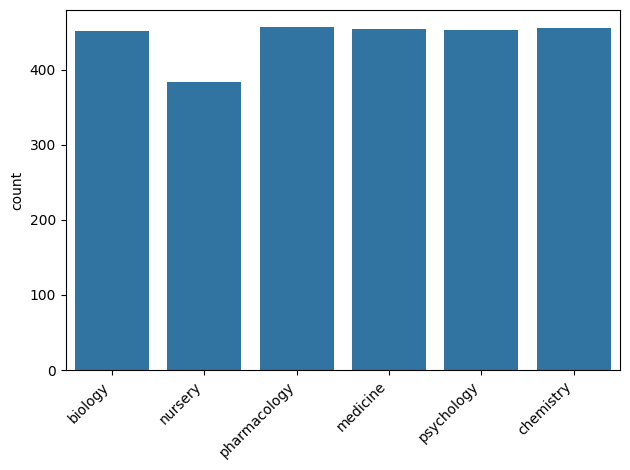

In [ ]:
categorias = [ejemplo['category'] for ejemplo in train_data]  # Extrae las categorías del conjunto de entrenamiento
distribucion_categorias = Counter(categorias)
print(distribucion_categorias)

sns.countplot(x=categorias)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
longitudes_preguntas = [len(ejemplo['qtext'].split()) for ejemplo in train_data]
longitudes_respuestas = [len(respuesta['atext'].split()) for ejemplo in train_data for respuesta in ejemplo['answers']] # Aplanamos la lista de respuestas

print(f"Longitud promedio de las preguntas: {np.mean(longitudes_preguntas)}")
print(f"Longitud máxima de las preguntas: {np.max(longitudes_preguntas)}")
print(f"Longitud promedio de las respuestas: {np.mean(longitudes_respuestas)}")
print(f"Longitud máxima de las respuestas: {np.max(longitudes_respuestas)}")

Longitud promedio de las preguntas: 20.85246518630034
Longitud máxima de las preguntas: 189
Longitud promedio de las respuestas: 6.167181031238239
Longitud máxima de las respuestas: 49


## Preprocesamiento && Entrenamiento

### Para Redes Recurrentes RNNs

Función de preprocesamiento usando el tokenizer en todos los conjuntos

In [ ]:
def preprocesar_datos(datos, max_length, max_tokens):
    preguntas = []
    respuestas = []
    etiquetas = []

    for ejemplo in datos:
        pregunta = ejemplo['qtext']
        opciones_respuestas = [resp['atext'] for resp in ejemplo['answers']]
        respuesta_correcta = int(ejemplo['ra']) - 1  # Restamos uno porque los indices empiezan en 0
        preguntas.append(pregunta)
        respuestas.append(opciones_respuestas)  # Lista de respuestas para cada pregunta
        etiquetas.append(respuesta_correcta)    # Indice de la respuesta correcta

    # Tokenización
    text_vectorization = TextVectorization(
        max_tokens=max_tokens,
        output_mode="int",
        output_sequence_length=max_length,
    )
    text_vectorization.adapt(preguntas)  # Adaptar solo con las preguntas

    preguntas_tokenizadas = text_vectorization(np.array(preguntas))

    # Tokenizar y hacer padding de las respuestas
    respuestas_padded = []
    for lista_respuestas in respuestas:
        respuestas_padded_pregunta = []
        for respuesta in lista_respuestas:
            # Tokenizar la respuesta (sin la dimensión extra)
            respuesta_tokenizada = text_vectorization(np.array([respuesta])).numpy()[0]

            # Asegurarse de que el padding reciba una lista de tokens
            respuesta_padded = tf.keras.preprocessing.sequence.pad_sequences(
                [respuesta_tokenizada], maxlen=max_length, padding='post'
            )[0]  # Eliminar la dimensión extra después del padding

            respuestas_padded_pregunta.append(respuesta_padded)
        respuestas_padded.append(respuestas_padded_pregunta)

    # Convertir a arrays de numpy
    preguntas_padded = preguntas_tokenizadas.numpy()
    respuestas_padded = np.array(respuestas_padded)
    etiquetas = np.array(etiquetas)

    return preguntas_padded, respuestas_padded, etiquetas, text_vectorization


In [ ]:
max_length = 25
max_tokens = 10000

In [ ]:
preguntas_train, respuestas_train, etiquetas_train, text_vectorization = preprocesar_datos(train_data, max_length, max_tokens)

In [ ]:
print("Datos de entrenamiento:")
print(preguntas_train.shape)
print(respuestas_train.shape)
print(etiquetas_train.shape)

Datos de entrenamiento:
(2657, 25)
(2657, 5, 25)
(2657,)


In [ ]:
print(f"Pregunta tokenizada: {preguntas_train[100]}")
print(f"Respuestas tokenizadas: {respuestas_train[100]}")
print(f"Etiqueta: {etiquetas_train[100]}")

Pregunta tokenizada: [   4   12 5453    2   12 1990 3711 1713    6  174    9    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Respuestas tokenizadas: [[   5 1990  709   24 2217    4    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  13  124   21 8959   21 4294    5 1990    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   5 1990    1    7    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [  13  124 8959  241    7  854 5174    1    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   5 1990    1    7 2448    4    3    1    2  384    1    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Etiqueta: 1


In [ ]:
preguntas_val, respuestas_val, etiquetas_val, _ = preprocesar_datos(validation_data, max_length, max_tokens)

In [ ]:
print("Datos de validación:")
print(preguntas_val.shape)
print(respuestas_val.shape)
print(etiquetas_val.shape)

Datos de validación:
(1366, 25)
(1366, 4, 25)
(1366,)


In [ ]:
print(f"Pregunta tokenizada: {preguntas_val[100]}")
print(f"Respuestas tokenizadas: {respuestas_val[100]}")
print(f"Etiqueta: {etiquetas_val[100]}")

Pregunta tokenizada: [  14 1398 3310 1140  159    2   12  585    2  488   36  922  399   11
   14  372   19    0    0    0    0    0    0    0    0]
Respuestas tokenizadas: [[1627    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Etiqueta: 3


In [ ]:
preguntas_test, respuestas_test, etiquetas_test, _ = preprocesar_datos(test_data, max_length, max_tokens)

In [ ]:
print("Datos de prueba:")
print(preguntas_test.shape)
print(respuestas_test.shape)
print(etiquetas_test.shape)

Datos de prueba:
(2742, 25)
(2742, 4, 25)
(2742,)


In [ ]:
print(f"Pregunta tokenizada: {preguntas_test[100]}")
print(f"Respuestas tokenizadas: {respuestas_test[100]}")
print(f"Etiqueta: {etiquetas_test[100]}")

Pregunta tokenizada: [  16    9    5 7008 1751    2 2712 5764    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
Respuestas tokenizadas: [[   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1 5089    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
Etiqueta: 0


###### Modelo 1: LSTM

Creación

In [ ]:
def modelo_lstm(input_shape, max_length, num_clases):
    inputs = Input(shape=input_shape)
    embedding = Embedding(input_dim=max_tokens, output_dim=128)(inputs)
    lstm = LSTM(64, return_sequences=False)(embedding)
    dropout = Dropout(0.5)(lstm)
    output = Dense(num_clases, activation='softmax')(dropout)  # Softmax para clasificación multi-clase
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
modelo_lstm = modelo_lstm((max_length,), max_length, 5)

Run

In [ ]:
# Entrenamiento
history_lstm = modelo_lstm.fit(
    preguntas_train,
    etiquetas_train,
    epochs=10,
    batch_size=16,
    validation_data=(preguntas_val, etiquetas_val),
    verbose=2
)

Epoch 1/10
167/167 - 6s - 33ms/step - accuracy: 0.2070 - loss: 1.6080 - val_accuracy: 0.2482 - val_loss: 1.5612
Epoch 2/10
167/167 - 3s - 15ms/step - accuracy: 0.2691 - loss: 1.5968 - val_accuracy: 0.2518 - val_loss: 1.5580
Epoch 3/10
167/167 - 1s - 7ms/step - accuracy: 0.3553 - loss: 1.5122 - val_accuracy: 0.2291 - val_loss: 1.6108
Epoch 4/10
167/167 - 1s - 6ms/step - accuracy: 0.5883 - loss: 1.0863 - val_accuracy: 0.2094 - val_loss: 1.8463
Epoch 5/10
167/167 - 1s - 7ms/step - accuracy: 0.7904 - loss: 0.6088 - val_accuracy: 0.2167 - val_loss: 2.3969
Epoch 6/10
167/167 - 2s - 10ms/step - accuracy: 0.9093 - loss: 0.3021 - val_accuracy: 0.2167 - val_loss: 2.6239
Epoch 7/10
167/167 - 2s - 13ms/step - accuracy: 0.9477 - loss: 0.1754 - val_accuracy: 0.2130 - val_loss: 3.2254
Epoch 8/10
167/167 - 1s - 7ms/step - accuracy: 0.9646 - loss: 0.1229 - val_accuracy: 0.2101 - val_loss: 3.7425
Epoch 9/10
167/167 - 1s - 8ms/step - accuracy: 0.9646 - loss: 0.1237 - val_accuracy: 0.2101 - val_loss: 3.66

In [ ]:
# Evaluación en el conjunto de prueba
loss, accuracy = modelo_lstm.evaluate(preguntas_test, etiquetas_test)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1905 - loss: 3.8284
Precisión en el conjunto de prueba: 0.1984


###### Modelo 2: GRU

Creación

In [ ]:
def modelo_gru(input_shape, max_length, num_clases):
    inputs = Input(shape=input_shape)
    embedding = Embedding(input_dim=max_tokens, output_dim=128)(inputs)
    gru = GRU(64, return_sequences=False)(embedding)
    dropout = Dropout(0.5)(gru)
    output = Dense(num_clases, activation='softmax')(dropout)  # Softmax para clasificación multi-clase
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Configuración del modelo GRU
modelo_gru = modelo_gru((max_length,), max_length, 5)

Run

In [ ]:
# Entrenamiento
history_gru = modelo_gru.fit(
    preguntas_train,
    etiquetas_train,
    epochs=10,
    batch_size=16,
    validation_data=(preguntas_val, etiquetas_val)
)

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1954 - loss: 1.6101 - val_accuracy: 0.2548 - val_loss: 1.5747
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2660 - loss: 1.5957 - val_accuracy: 0.2365 - val_loss: 1.5719
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3085 - loss: 1.5710 - val_accuracy: 0.2474 - val_loss: 1.5952
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4599 - loss: 1.3097 - val_accuracy: 0.2116 - val_loss: 1.7645
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6273 - loss: 0.9129 - val_accuracy: 0.1830 - val_loss: 2.1545
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8124 - loss: 0.5418 - val_accuracy: 0.2438 - val_loss: 2.6078
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8655 - loss: 0.4216 - val_accuracy: 0.2189 - val_loss: 3.2687
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9562 - loss: 0.1539 - val_accuracy: 0.

In [ ]:
# Evaluación en el conjunto de prueba
loss, accuracy = modelo_gru.evaluate(preguntas_test, etiquetas_test)
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1888 - loss: 4.3779
Precisión en el conjunto de prueba: 0.1958


### Para transformers

Tokenizer

In [ ]:
# Tokenizer para BioBERT y DistilBERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

Función de preprocesamiento usando el tokenizer en todos los conjuntos

In [ ]:
"""
  Esta función está diseñada para preparar el conjunto de datos para su el modelo Transformer BERT.
  Los modelos Transformer requieren que los datos estén en un formato específico.
"""
def preprocess_transformers(data):
    input_ids, attention_masks, labels = [], [], []
    for example in data:
        question = example['qtext']
        options = " ".join([f"({ans['aid']}) {ans['atext']}" for ans in example['answers']])
        encoded = tokenizer(
            question,
            text_pair=options,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'].squeeze())
        attention_masks.append(encoded['attention_mask'].squeeze())
        labels.append(example['ra'] - 1)
    return input_ids, attention_masks, labels

In [ ]:
# Función para convertir a tensores
def convert_to_tensor(inputs, masks, labels):
    return TensorDataset(torch.stack(inputs), torch.stack(masks), torch.tensor(labels))

In [ ]:
# Cargar y preparar los datos
train_inputs, train_masks, train_labels = preprocess_transformers(train_data)
val_inputs, val_masks, val_labels = preprocess_transformers(validation_data)
test_inputs, test_masks, test_labels = preprocess_transformers(test_data)

In [ ]:
# Ver un ejemplo del conjunto procesado
print("Input IDs de entrenamiento:", train_inputs[0])
print("Attention mask de entrenamiento:", train_masks[0])
print("Etiqueta de entrenamiento:", train_labels[0])

Input IDs de entrenamiento: tensor([  101, 12724,  9814,  1424, 12562,  1279,  8345,  2983,  8956,  2155,
         4252,  6617, 18518, 12238,   131,   102,   113,   122,   114,  1488,
         1260,  5580,  1186,  1106,  2572,   184,  9468,  1810,   119,   113,
          123,   114,  1488,  5110,  1200, 23043,  7710, 14883,  3052,   119,
          113,   124,   114, 14516, 23609, 15018,  1179,  7584,  1813,   119,
          113,   125,   114, 14516, 21146, 18323,   170,  2495, 18971,  1116,
         4267, 13946,  6052,  1116,   119,   113,   126,   114,  1675,  1389,
         8362,  1669,  1186,  1231, 27476,  5822, 20438,   119,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0, 

In [ ]:
# Convertir a tensores
train_dataset = convert_to_tensor(train_inputs, train_masks, train_labels)
val_dataset = convert_to_tensor(val_inputs, val_masks, val_labels)
test_dataset = convert_to_tensor(test_inputs, test_masks, test_labels)

In [ ]:
# Cargar los datos a loaders de torch
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
# Definir la configuración para los modelos
num_classes = 5

In [ ]:
models = {
    "BioBERT": AutoModelForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=num_classes),
    "DistilBERT": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)
}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizers = {
    name: AdamW(model.parameters(), lr=2e-5)
    for name, model in models.items()
}

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Entrenamiento y evaluación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for model in models.values():
    model.to(device)

In [ ]:
def train_transformer(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in loader:
        inputs, masks, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids=inputs, attention_mask=masks, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), correct / total

## Evaluación && Rendimiento


### Redes recurrentes

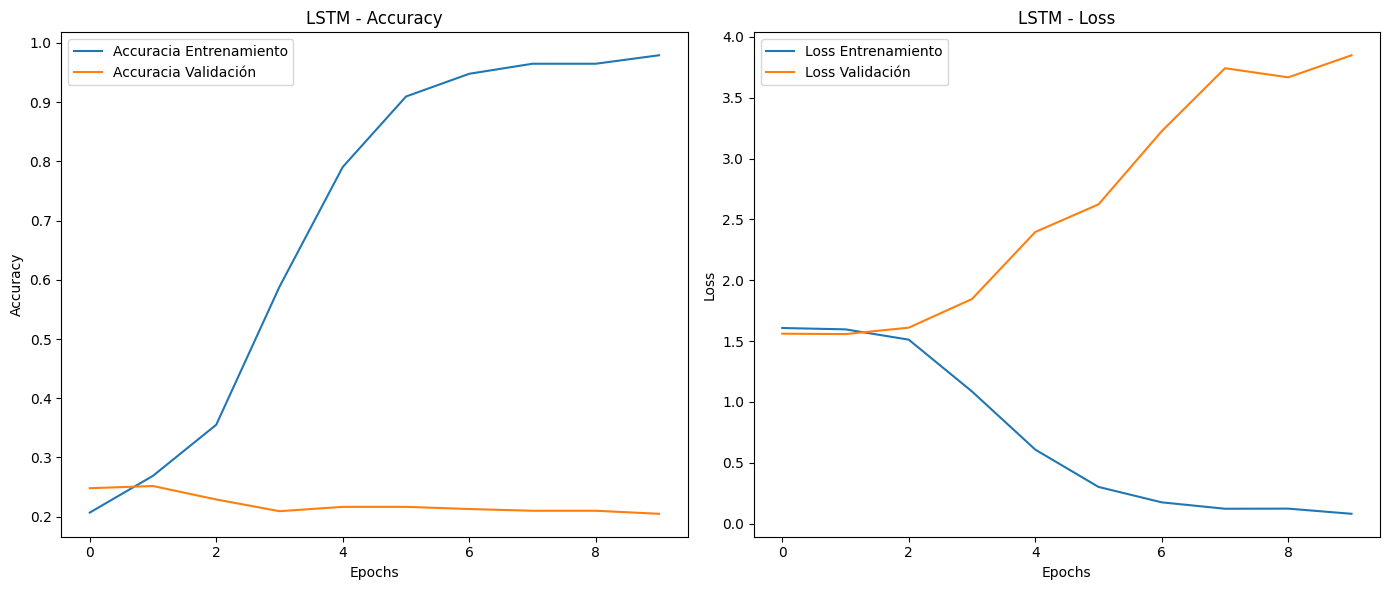

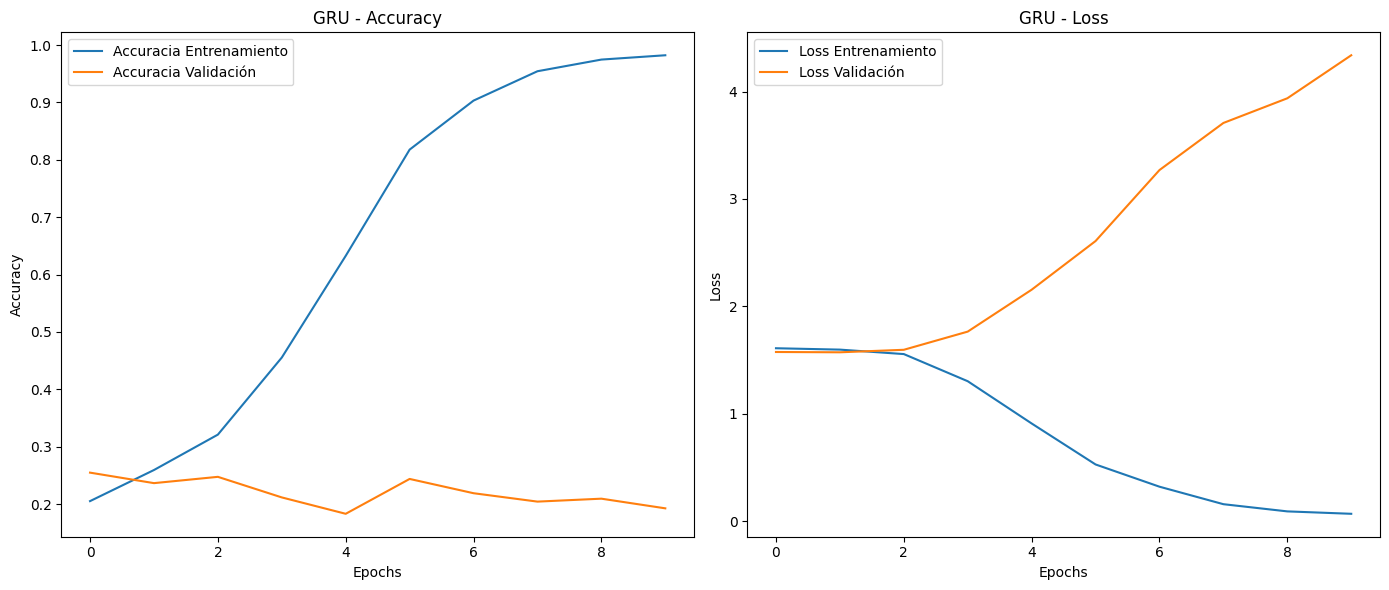

In [ ]:
# Función para graficar el rendimiento
def graficar_resultados(history, modelo_nombre):
    # Gráficas de accuracy y loss
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfica de accuracy
    ax[0].plot(history.history['accuracy'], label='Accuracia Entrenamiento')
    ax[0].plot(history.history['val_accuracy'], label='Accuracia Validación')
    ax[0].set_title(f'{modelo_nombre} - Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Gráfica de loss
    ax[1].plot(history.history['loss'], label='Loss Entrenamiento')
    ax[1].plot(history.history['val_loss'], label='Loss Validación')
    ax[1].set_title(f'{modelo_nombre} - Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Graficamos los resultados de LSTM
graficar_resultados(history_lstm, "LSTM")

# Graficamos los resultados de GRU
graficar_resultados(history_gru, "GRU")


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


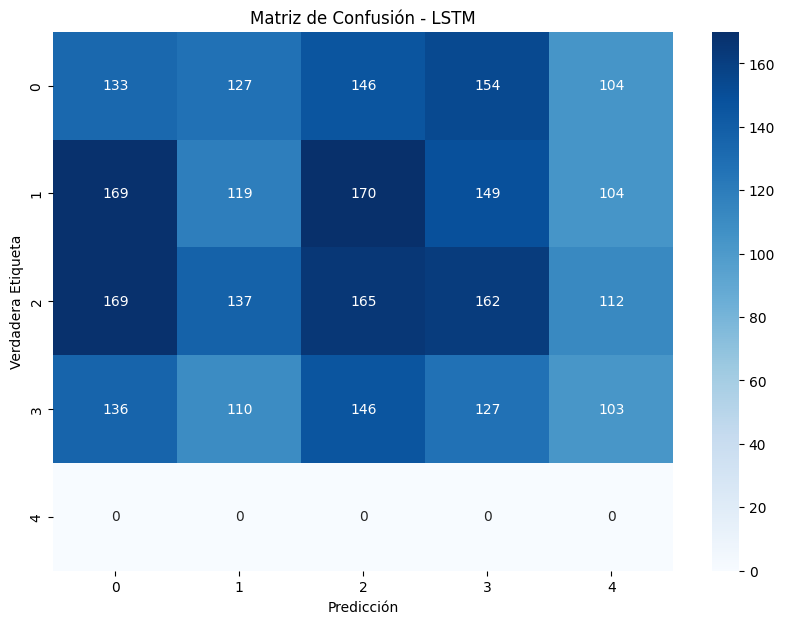

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


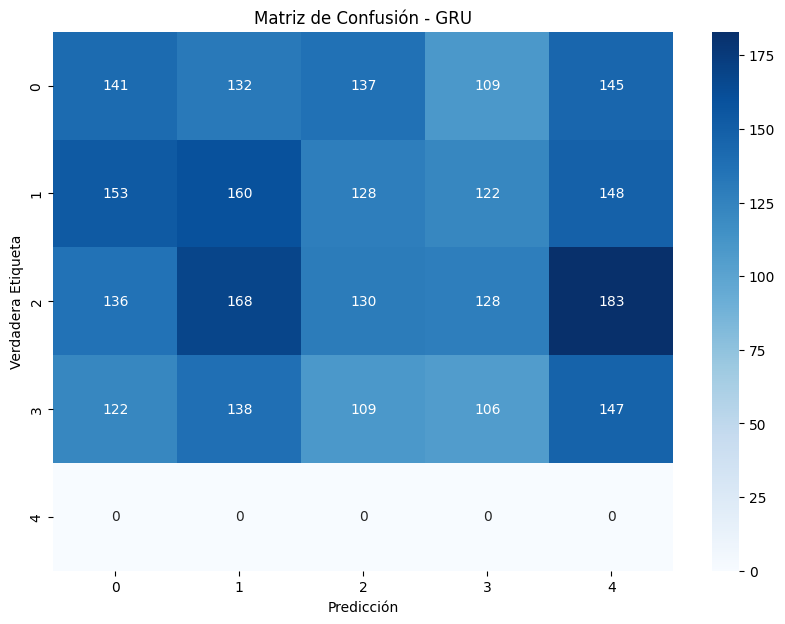

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predicción con LSTM
y_pred_lstm = modelo_lstm.predict(preguntas_test)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

# Matriz de confusión LSTM
cm_lstm = confusion_matrix(etiquetas_test, y_pred_lstm)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Matriz de Confusión - LSTM")
plt.xlabel('Predicción')
plt.ylabel('Verdadera Etiqueta')
plt.show()

# Predicción con GRU
y_pred_gru = modelo_gru.predict(preguntas_test)
y_pred_gru = np.argmax(y_pred_gru, axis=1)

# Matriz de confusión GRU
cm_gru = confusion_matrix(etiquetas_test, y_pred_gru)

# Visualización de la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Matriz de Confusión - GRU")
plt.xlabel('Predicción')
plt.ylabel('Verdadera Etiqueta')
plt.show()

### Transformers

In [ ]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            inputs, masks, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=inputs, attention_mask=masks)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return correct / total, all_preds, all_labels

BioBERT - Epoch 1, Loss: 1.6176, Val Accuracy: 0.2511
BioBERT - Epoch 2, Loss: 1.6096, Val Accuracy: 0.2584
BioBERT - Epoch 3, Loss: 1.6027, Val Accuracy: 0.2716
BioBERT - Epoch 4, Loss: 1.6009, Val Accuracy: 0.2562
BioBERT - Epoch 5, Loss: 1.5721, Val Accuracy: 0.2635
BioBERT Accuracy - Train: 0.3798, Val: 0.2635, Test: 0.2553


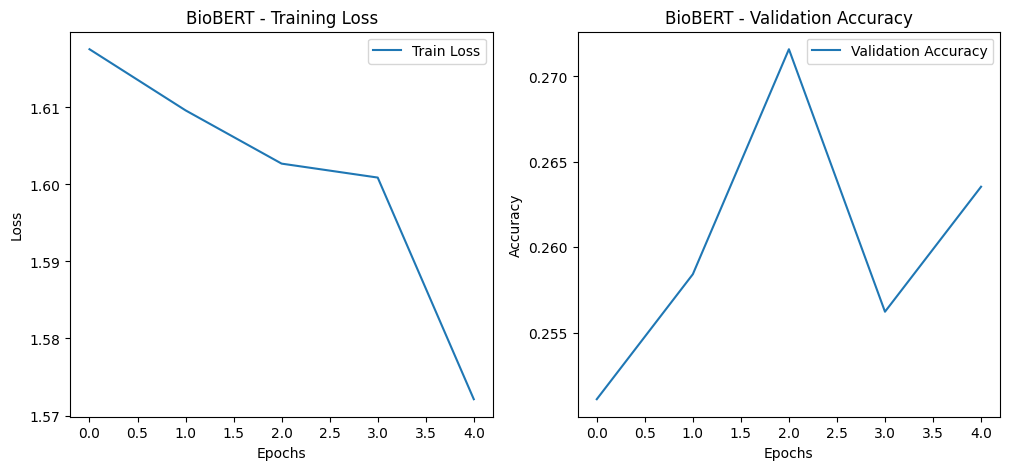

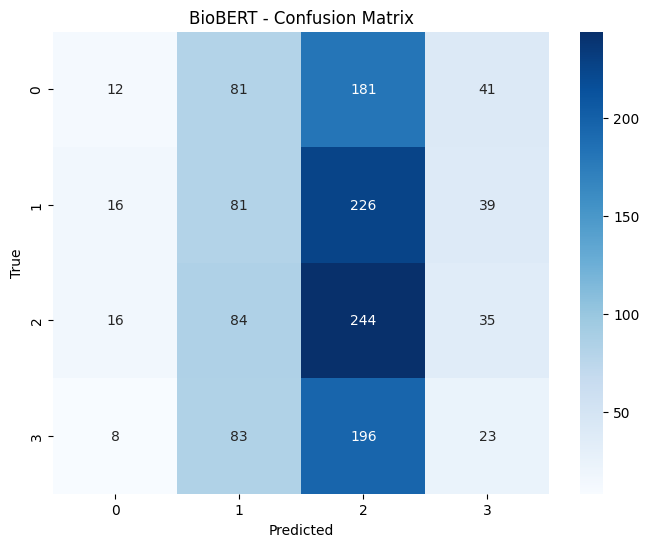

DistilBERT - Epoch 1, Loss: 1.6096, Val Accuracy: 0.2650
DistilBERT - Epoch 2, Loss: 1.6073, Val Accuracy: 0.2269
DistilBERT - Epoch 3, Loss: 1.6069, Val Accuracy: 0.2306
DistilBERT - Epoch 4, Loss: 1.6037, Val Accuracy: 0.2269
DistilBERT - Epoch 5, Loss: 1.6026, Val Accuracy: 0.2657
DistilBERT Accuracy - Train: 0.2454, Val: 0.2657, Test: 0.2626


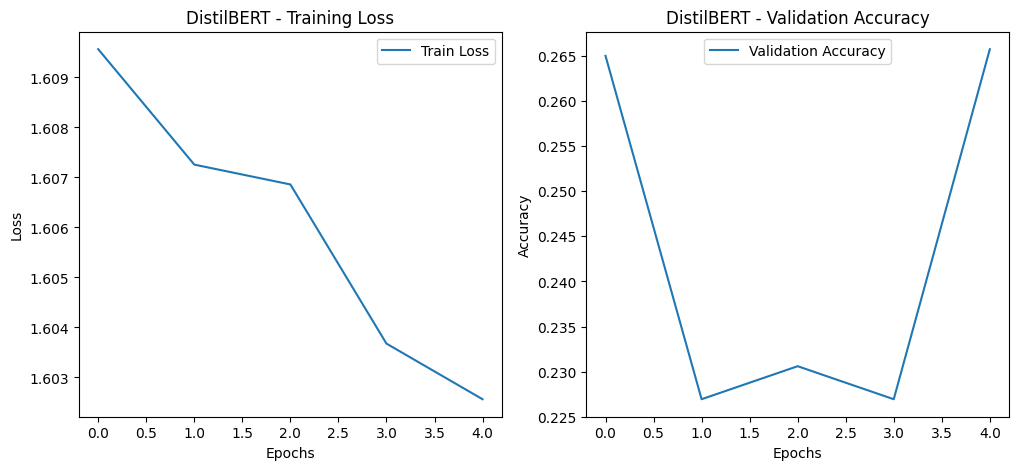

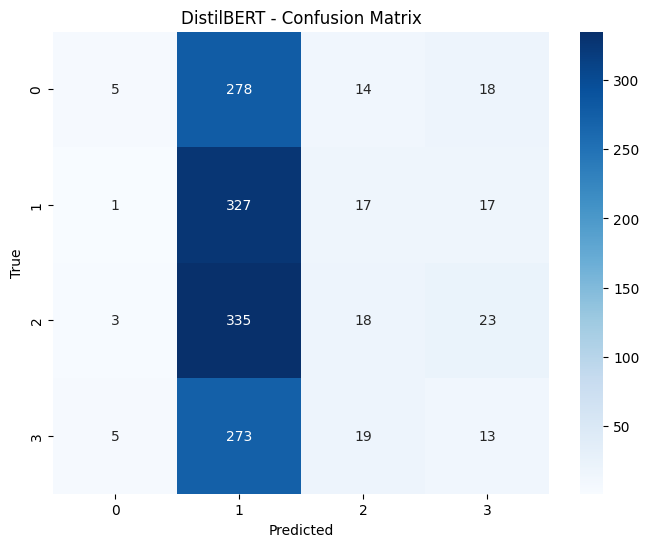

In [ ]:
# Entrenar y evaluar los modelos
results = {}
for name, model in models.items():
    train_losses, val_accuracies = [], []
    for epoch in range(5):
        train_loss, train_acc = train_transformer(model, train_loader, optimizers[name])
        val_acc, _, _ = evaluate(model, val_loader)
        train_losses.append(train_loss)
        val_accuracies.append(val_acc)
        print(f"{name} - Epoch {epoch+1}, Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    results[name] = {"train_losses": train_losses, "val_accuracies": val_accuracies}

    # Evaluación final
    train_acc, _, _ = evaluate(model, train_loader)
    val_acc, val_preds, val_labels = evaluate(model, val_loader)
    test_acc, _, _ = evaluate(model, test_loader)

    print(f"{name} Accuracy - Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

    # Gráficos
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{name} - Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{name} - Validation Accuracy')
    plt.legend()
    plt.show()

    # Matriz de confusión
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()